In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab2/data/'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab2/data/'
resultsFolder = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab2/results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cat.10000.jpg  hr-train.npy   mnist	   res-test.npy   vgg-train.npy
CatDog	       inc.pt	      model.ckpt   res-train.npy
hr.pt	       inc-test.npy   models.ckpt  vgg.pt
hr-test.npy    inc-train.npy  res.pt	   vgg-test.npy


In [0]:
##task -> create your own architecture on cat/dog dataset, get the highest possible
##accuracy. You may use sigmoid or cross correlation loss setup.
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

#Task use cat/dog dataseet, load the data and add additional transform -> Resize, totensor, normalize
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for tensor, mean, std in zip(tensor, self.mean, self.std):
            tensor.mul_(std).add_(mean)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [0]:
default_directory = os.path.join(myDrive, 'CatDog/train')

class CatDog(torch.utils.data.Dataset):
    
    def __init__(self, transform, *, dataDir = default_directory):
        #Initialize the data and label list
        self.labels = []
        self.data = []
        
        #First load all images data
        listImage = os.listdir(dataDir)
        
        for x in listImage:
            #Second filter according name for labelling : cat : 1, dog : 0
            lbl = 1 if 'cat' in x else 0
            # Append to our class attribute :)
            path = os.path.join(dataDir, x)
            self.data.append(path)
            self.labels.append(lbl)
        
        
    def __getitem__(self, index):
        img = Image.open(self.data[index])
        img = transform(img)
        return img, self.labels[index]
      

    def __len__(self):
        return len(self.data)
 

tr = []  #
tr.append(T.Resize((128, 128)))
tr.append(T.ToTensor())
tr.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[.5, .5, .5]))
transform = T.Compose(tr)
UN = UnNormalize(mean=(.5,.5,.5),std=(.5,.5,.5))

In [0]:
#!Task one, design your network
class HourGlassSim(nn.Module):
    def __init__(self, num_classes=10):
        super(HourGlassSim, self).__init__()
        
        self.convols11_12 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.intermediates = nn.Sequential(
            nn.Linear(31, 512),
            nn.Linear(512,31)
        )
        
        self.convols21_22 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
        )
        
        self.fc = nn.Linear(1048576, num_classes)
        
    def forward(self, x):
      
        out11_12 = self.convols11_12(x)
        #print(out11_12.size())
        intermediate = self.intermediates(out11_12)
        #print(out11_12.size())
        #intermediate = intermediate.view(intermediate.size(0),64,6,6)
        #print(out11_12.size())
        
        out21_22 = self.convols21_22(intermediate)
        #print(out11_12.size())
        
        out21_22 = out21_22.reshape(out21_22.size(0), -1)
        #print(out11_12.size())
        out = self.fc(out21_22)
        #print(out.size())
        
        return out

In [0]:
class ResNetSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResNetSim, self).__init__()
        
        self.convols11_12 = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU()
        )
        
        self.convols21_22 = nn.Sequential(
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
        )
        
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(262144, num_classes)
        
    def forward(self, x):
        
        convols11_12 = self.convols11_12(x)
        convols21_22 = self.convols21_22(convols11_12)
        
        pooling = self.MaxPooling(convols21_22)
        
        pooling = pooling.reshape(pooling.size(0), -1)
        out = self.fc(pooling)
        #print(out.size())
        
        return out

In [0]:
#! Task two, define your network, hyperparameters, optimizer etc.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
fName = 'HourGlass' #'ResNet'
CNN = HourGlassSim() #ResNetSim()
CNN = CNN.to(device)

#criterion
criterion = nn.CrossEntropyLoss()

#optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)

# epochs
num_epochs = 10

In [0]:
# Task three, train the model
if True :
     
    CDTrain = CatDog(transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset=CDTrain,
                                               batch_size=64,shuffle=True)
    loss_train = []
    
    print('training')
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
          out = CNN(images.to(device))
          loss = criterion(out, labels.to(device))  
          optimizer.zero_grad()
          loss.backward()
          loss_train.append(loss.item())
          optimizer.step()
          
        print('Epoch: ' +str(epoch)+ ' trained!' )
          
    
    # Save the model checkpoint and the loss results
    loss_train = np.asarray(loss_train)
    np.save(resultsFolder+fName+'-train.npy',loss_train)
    torch.save(CNN.state_dict(), resultsFolder+fName+'Model.ckpt')

training
Epoch: 0 trained!
Epoch: 1 trained!
Epoch: 2 trained!
Epoch: 3 trained!
Epoch: 4 trained!
Epoch: 5 trained!
Epoch: 6 trained!
Epoch: 7 trained!
Epoch: 8 trained!
Epoch: 9 trained!


In [41]:
#Task four, test the model and record your accuracy.
accuracies_lst = []
loss_test= []

for i in range(2): 
    if i == 0: 
        CNN = HourGlassSim()
        fName = 'HourGlass'
    elif  i == 1: 
        CNN = ResNetSim()
        fName = 'ResNet'
    
    CNN.load_state_dict(torch.load(resultsFolder+fName+'Model.ckpt'))
    CNN.to(device)
    CDTest = CatDog('./CatDog/t_s/')
    test_loader = torch.utils.data.DataLoader(CDTest, batch_size=64, shuffle=True)
    
    CNN.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    loss_test = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = CNN(images)
            loss = criterion(outputs, labels.to(device))
            loss_test.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        #save loss and accuracy
        loss_train = np.asarray(loss_test)
        np.save(resultsFolder+fName+'-test.npy',loss_test)
        accuracy = 100 * correct / total
        accuracies_lst.append(accuracy)
        print(fName+ ' model tested and accuracy computed and saved!')
        #DEBUG
        #print(correct)
        #print(total)
        #print('Test Accuracy of the model on the 10000 test images: {} %'.format(accuracy))

HourGlass model tested and accuracy computed and saved!
ResNet model tested and accuracy computed and saved!


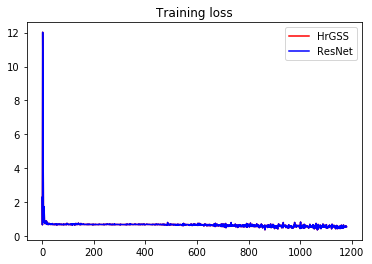

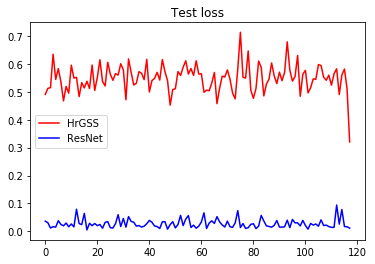



Accuracy of HourGlass: 72.70666666666666 %


Accuracy of ResNet: 99.46666666666667 %


In [0]:
#EXECUTE AFTER EXECUTING ALL ABOVE FOR HourGlass AND THEN for ResNet

# load both losses
HrGTrain, HrGTest = np.load(resultsFolder+'HourGlass-train.npy'),np.load(resultsFolder+'HourGlass-test.npy')
RsNtTrain, RsNtTest = np.load(resultsFolder+'ResNet-train.npy'), np.load(resultsFolder+'ResNet-test.npy')

# plot both losses in the training and the test
# TRAIN
figure, axis = plt.subplots()
axis.plot(HrGTrain,'r',label='HrGSS')
axis.plot(HrGTrain,'b',label='ResNet')
legend = axis.legend()
plt.title('Training loss')
plt.show()

# TEST
figure, axis = plt.subplots()
axis.plot(HrGTest,'r',label='HrGSS')
axis.plot(RsNtTest,'b',label='ResNet')
legend = axis.legend()
plt.title('Test loss')
plt.show()

# print accuracies
for i in range(len(accuracies_lst)): 
    if i == 0: 
        Name = 'HourGlass'
    elif  i == 1: 
        Name = 'ResNet'

    print('\n')
    print('Accuracy of '+Name+': {} %'.format(accuracies_lst[i]))